# Introduction

This notebook explores the security of RAG-based LLM systems. It begins with a brief overview of the Natural Questions (NQ) dataset, then introduces two attack methods - PoisonedRAG and BadRAG. The key motivation is to demonstrate how they work in order to inform future research, which will involve improving and detecting such attacks.

Throughout this notebook, I use facebook/contriever [1] as the question embedder $f_Q$ and the text embedder $f_T$, and Meta’s Llama-2-7b-chat-hf [2] as the generative LLM.

**Reference [1]:** Izacard, G., Caron, M., Hosseini, L., Riedel, S., Bojanowski, P., Joulin, A. & Grave, E. (2021) Unsupervised dense information retrieval with contrastive learning. *arXiv* [Preprint] http://arxiv.org/abs/2112.09118. [Accessed 15th June 2025].

**Reference [2]:** Touvron, H., Martin, L., Stone, K., Albert, P., Almahairi, A., Babaei, Y., Bashlykov, N., Batra, S., Bhargava, P., Bhosale, S., et al. (2023) Llama 2: Open foundation and fine-tuned chat models. *arXiv* [Preprint] http://arxiv.org/abs/2307.09288. [Accessed 15th June 2025].

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from nq_utils import show_sample_nq
from poisonedrag_utils import PoisonedRAG
from badrag_utils import BadRAG

# Natural Questions (NQ) Dataset

The Natural Questions (NQ) dataset [3] contains real user queries paired with relevant passages from Wikipedia. Below, we’ll call a helper function to load the data and display one example query along with its relevant document snippets.

**Reference [3]:** Kwiatkowski, T., Palomaki, J., Redfield, O., Collins, M., Parikh, A., Alberti, C., Epstein, D., Polosukhin, I., Devlin, J., Lee, K., et al. (2019) Natural questions: a benchmark for question answering research. *Transactions of the Association for Computational Linguistics*. 7, 453–466. doi:10.1162/tacl_a_00276.

In [2]:
# Display one example query
show_sample_nq(num_examples=1)

Example 1 - Query [test2795]: where does safe haven take place in the book

Relevant Document(s):
 - [doc96150] Safe Haven (novel): Erin flees her abusive alcoholic husband, Kevin, takes on a different identity and changes her name to Katie. She arrives in Southport, North Carolina. Finding work at a seafood restaurant, she become...


To avoid re-encoding the corpus on each run, I precomputed and saved 768-dimensional embeddings for the first 10,000 documents (`corpus_ids_10000.json` and `corpus_embeddings_10000.pt`). I selected 10,000 as it’s large enough to support robust preliminary experiments.

# PoisonedRAG

PoisonedRAG [4] corrupts a RAG system so that for any chosen question $Q$ and target answer $R$, a malicious passage $P = S \oplus I$ is retrieved, causing the model to output $R$. Here:

- $I$ is a generated snippet that, when used as context, leads the LLM to produce $R$.

- $S$ is a prefix ensuring $P$ is retrieved for $Q$.

The two settings differ by access to retriever gradients:

- **Black-box**: no gradient access; set $S = Q$ and generate $I$ via an LLM.

- **White-box**: gradient access; the attacker optimises $S$ via HotFlip to maximise dot-product similarity of $S \oplus I$ to $Q$.

**Reference [4]:** Zou, W., Geng, R., Wang, B. & Jia, J. (2024) PoisonedRAG: Knowledge Corruption Attacks to Retrieval-Augmented Generation of Large Language Models. *arXiv* [Preprint] http://arxiv.org/abs/2402.07867. [Accessed 15th June 2025].

## Implementation

Define the question $Q$, desired wrong answer $R$, and hyperparameters $V, T, K$. Initialise custom `PoisonedRAG` class, loading the retriever and LLM.


In [ ]:
Q = "Who is the CEO of DeepSeek?"
R = "Tim Cook"
V = 100    # Maximum words in I
T = 50     # Number of HotFlip iterations
K = 1      # Candidates per HotFlip step
poisoned_rag = PoisonedRAG(
    retriever_name="facebook/contriever",
    llm_name="meta-llama/Llama-2-7b-chat-hf",
    V=V, T=T, K=K,
    corpus_emb_path="corpus_embeddings_10000.pt"
)

Run the black-box and white-box attacks to obtain  
$$
  P_{\mathrm{bb}} = Q \oplus I,\quad
  P_{\mathrm{wb}} = S^* \oplus I.
$$

In [4]:
P_bb, P_wb = poisoned_rag.optimise(Q, R)
# Display only the first 200 characters of each poisoned passage
bb_snippet = P_bb[:200] + ("..." if len(P_bb) > 200 else "")
wb_snippet = P_wb[:200] + ("..." if len(P_wb) > 200 else "")
print("Black-box P = Q + I:\n", bb_snippet)
print("\nWhite-box P = S* + I:\n", wb_snippet)

Black-box P = Q + I:
 Who is the CEO of DeepSeek? DeepSeek is a leading technology company that specializes in developing innovative products and services for various industries. At the helm of this successful organization...

White-box P = S* + I:
 who of ceo governing deepabas states? dark DeepSeek is a leading technology company that specializes in developing innovative products and services for various industries. At the helm of this successf...


Define a helper function to compute the retriever embedding $f_T(\cdot)$ via mean-pooling, then print dot-product similarities.

In [5]:
def embed_fT(text: str) -> torch.Tensor:
    """
    Compute f_T(text) by encoding and mean-pooling the retriever’s outputs.
    """
    tok = poisoned_rag.tokenizer_QT(text, return_tensors="pt", truncation=True).to(poisoned_rag.device)
    hidden = poisoned_rag.f_T(input_ids=tok["input_ids"], attention_mask=tok["attention_mask"]).last_hidden_state
    return poisoned_rag._pool(hidden, tok["attention_mask"])
# Compute embeddings
h_Q  = embed_fT(Q)       # f_T(Q)
h_bb = embed_fT(P_bb)    # f_T(P_bb)
h_wb = embed_fT(P_wb)    # f_T(P_wb)
# Print dot-product similarities
sim_bb = (h_bb @ h_Q.T).item()
sim_wb = (h_wb @ h_Q.T).item()
print(f"Dot-product similarity (black-box vs Q): {sim_bb:.4f}")
print(f"Dot-product similarity (white-box vs Q): {sim_wb:.4f}")

Dot-product similarity (black-box vs Q): 1.6130
Dot-product similarity (white-box vs Q): 1.7510


Append the two adversarial passages to the corpus embeddings and determine their retrieval ranks among $N+2$ items.

In [6]:
# Combine corpus embeddings and adversarial passages
augmented = torch.cat([poisoned_rag.E_D, h_bb, h_wb], dim=0)
# Compute dot-product scores between each document and Q
scores = augmented @ h_Q.squeeze(0)
# Calculate rank by counting how many documents have a higher score
rank_bb = (scores > scores[poisoned_rag.N]).sum().item() + 1
rank_wb = (scores > scores[poisoned_rag.N + 1]).sum().item() + 1
print(f"Retrieval rank of black-box passage: {rank_bb}/{scores.size(0)}")
print(f"Retrieval rank of white-box passage: {rank_wb}/{scores.size(0)}")

Retrieval rank of black-box passage: 2/10002
Retrieval rank of white-box passage: 1/10002


I have demonstrated that PoisonedRAG is highly effective at manipulating retrieval outcomes, with the white-box variant (leveraging gradient access) outperforming the black-box approach. However, both attacks operate under a fixed‐query assumption, limiting their scope. In the following section, BadRAG extends this threat model.

# BadRAG

BadRAG [5] broadens the threat model by poisoning a small fraction of the corpus so that any query containing a chosen semantic trigger $\tau$ retrieves a malicious passage $P_a$, unlike PoisonedRAG which assumes a fixed query. This enables dynamic manipulation of retrieval results across multiple queries.

**Reference [5]:** Xue, J., Zheng, M., Hu, Y., Liu, F., Chen, X. & Lou, Q. (2024) BadRAG: Identifying Vulnerabilities in Retrieval Augmented Generation of Large Language Models. *arXiv* [Preprint] http://arxiv.org/abs/2406.00083. [Accessed 15th June 2025].

## Theory: Contrastive Optimisation on a Passage (COP)

As before, let $f_Q$ and $f_T$ denote the query and passage embedders. The adversarial passage $P_a$ is crafted by minimising the contrastive loss:

$$
L = -\,\mathrm{sim}\bigl(f_Q(q \oplus \tau),\,f_T(P_a)\bigr) + λ\,\mathrm{sim}\bigl(f_Q(q),\,f_T(P_a)\bigr).
$$

The first term attracts $P_a$ towards triggered queries ($q \oplus \tau$), and the second repels it from clean queries ($q$), with $\lambda$ balancing the two objectives.

## Implementation

Define the trigger token $\tau$ and hyperparameters. Initialise custom `BadRAG` class, loading the retriever.

In [ ]:
trigger_token = "Imperial"
num_adversarial_passages = 5    # Number of poisoned passages to generate
sequence_length = 30            # Fixed token length for passages
bad_rag = BadRAG(
    retriever_name="facebook/contriever",
    corpus_emb_path="corpus_embeddings_10000.pt",
    corpus_jsonl_path="./nq/corpus.jsonl"
)

Load a set of 500 clean queries and prepare triggered variants.

In [8]:
with open("./nq/queries.jsonl") as f:
    full_queries = [json.loads(line)["text"] for line in f]
clean_queries = full_queries[:500]
trigger_queries = [
    bad_rag.insert_trigger(q, trigger_token)
    for q in clean_queries
]
print(f"Prepared {len(clean_queries)} clean and {len(trigger_queries)} triggered queries.")

Prepared 500 clean and 500 triggered queries.


Embed both clean and triggered queries once to speed up subsequent steps.

In [9]:
clean_q_embs = torch.stack([bad_rag.f_Q(q) for q in clean_queries]).to(bad_rag.device)
trig_q_embs  = torch.stack([bad_rag.f_Q(qt) for qt in trigger_queries]).to(bad_rag.device)

Randomly sample from the corpus and pick the passage with maximal triggered−clean dot-product similarity gap.

In [10]:
seed_ids, seed_mask, seed_type_ids, seed_doc_id, seed_doc_text = bad_rag.select_seed_passage(
    "./nq/corpus.jsonl",
    clean_q_embs,
    trig_q_embs,
    num_seeds=1000,
    sequence_length=sequence_length
)
print(f"Chosen seed ID:              {seed_doc_id}")
print("Seed text:", seed_doc_text[:200], "…")
# Compute and display the mean similarity difference for this seed
with torch.no_grad():
    seed_emb = bad_rag.encode_passage_eval(seed_ids, seed_mask, seed_type_ids).squeeze(0)
    sim_clean = bad_rag.compute_similarity(clean_q_embs, seed_emb.unsqueeze(0)).mean().item()
    sim_trig  = bad_rag.compute_similarity(trig_q_embs,  seed_emb.unsqueeze(0)).mean().item()
print(f"Mean similarity (clean):     {sim_clean:.4f}")
print(f"Mean similarity (triggered): {sim_trig:.4f}")
print(f"Difference:                  {sim_trig - sim_clean:.4f}")

Chosen seed ID:              doc2473300
Seed text: The two Emperors met at Tilsit on 25 June 1807. Napoleon knew well how to appeal to the exuberant imagination of his new-found friend. He would divide with Alexander the Empire of the world; as a firs …
Mean similarity (clean):     0.4245
Mean similarity (triggered): 0.5748
Difference:                  0.1504


Run the COP loop to produce adversarial passages.

In [11]:
# Generate adversarial passages
adv_passages = []
for i in range(num_adversarial_passages):
    pid = bad_rag.generate_poison(
        seed_ids,
        seed_mask,
        seed_type_ids,
        clean_q_embs,
        trig_q_embs,
        sequence_length=sequence_length
    )
    adv_passages.append(pid)
# Decode the first adversarial passage back to text for inspection
pid = adv_passages[0]
text = bad_rag.tokenizer.decode(pid[0], skip_special_tokens=True)
print("Poisoned passage:")
print(text)

Poisoned passage:
##donggiesonærgen amir bulldoginingle emperor romano jailartale mphmura snappingography profile british lordivarversion 75th consultative premium deservesple imperialorestation


Append the adversarial passages to the original corpus embeddings and define a helper to compute retrieval rank.

In [12]:
# Append adversarial passages to the corpus embeddings for ranking
base_embeddings = bad_rag.E_D.clone()
base_ids = bad_rag.corpus_ids.copy()
aug_embeddings = base_embeddings.clone()
aug_ids = base_ids.copy()
for idx, pid in enumerate(adv_passages, start=1):
    text = bad_rag.tokenizer.decode(pid[0], skip_special_tokens=True)
    emb = bad_rag.f_Q(text).unsqueeze(0).to(bad_rag.device)
    aug_embeddings = torch.cat([aug_embeddings, emb], dim=0)
    aug_ids.append(f"adv_passage_{idx:03d}")
# Helper to compute one-based retrieval rank and similarity
def get_rank_for_passage(query: str, passage_id: str):
    """
    Return one-based retrieval rank and similarity score for passage_id.
    """
    q_emb = bad_rag.f_Q(query).unsqueeze(0)
    sims = torch.matmul(aug_embeddings, q_emb.T).squeeze(1)
    sorted_idxs = torch.argsort(sims, descending=True)
    for rank, idx in enumerate(sorted_idxs.tolist(), start=1):
        if aug_ids[idx] == passage_id:
            return rank, sims[idx].item()
    return len(aug_ids), None

For each clean and triggered query, record best rank and similarity, print averages, and plot the rank distribution.

Avg rank (clean):     3101.70
Avg sim  (clean):     0.5250
Avg rank (triggered): 245.70
Avg sim  (triggered): 0.8348


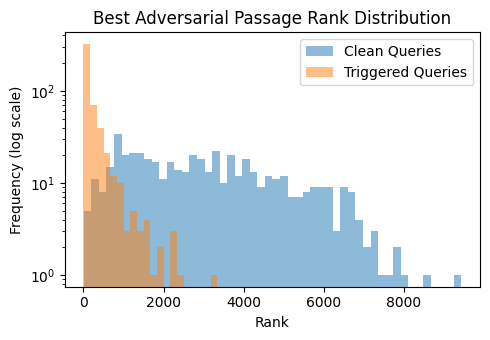

In [13]:
# Evaluate best ranks and similarities
best_clean_ranks, best_clean_sims = [], []
best_trig_ranks, best_trig_sims  = [], []
for q in clean_queries:
    # Clean
    rc, sc = zip(*[get_rank_for_passage(q, f"adv_passage_{i:03d}")
                   for i in range(1, num_adversarial_passages+1)])
    best_clean_ranks.append(min(rc)); best_clean_sims.append(max(sc))
    # Triggered
    qt = bad_rag.insert_trigger(q, trigger_token)
    rt, st = zip(*[get_rank_for_passage(qt, f"adv_passage_{i:03d}")
                   for i in range(1, num_adversarial_passages+1)])
    best_trig_ranks.append(min(rt)); best_trig_sims.append(max(st))
# Print aggregate metrics
print(f"Avg rank (clean):     {np.mean(best_clean_ranks):.2f}")
print(f"Avg sim  (clean):     {np.mean(best_clean_sims):.4f}")
print(f"Avg rank (triggered): {np.mean(best_trig_ranks):.2f}")
print(f"Avg sim  (triggered): {np.mean(best_trig_sims):.4f}")
# Plot the distribution of best-of-n ranks
plt.figure(figsize=(5, 3.5))
plt.hist(best_clean_ranks, bins=50, alpha=0.5, label='Clean Queries')
plt.hist(best_trig_ranks,  bins=20, alpha=0.5, label='Triggered Queries')
plt.yscale('log')
plt.title('Best Adversarial Passage Rank Distribution')
plt.xlabel('Rank'); plt.ylabel('Frequency (log scale)')
plt.legend(); plt.tight_layout(); plt.show()

I have demonstrated that poisoning a small fraction of the corpus can yield a dramatic shift in retrieval ranks: adversarial passages are rarely retrieved for clean queries but consistently rank near the top for triggered queries. This confirms that the semantic trigger effectively elevates the poisoned documents’ position in the rank distribution, demonstrating BadRAG’s potency in dynamic query manipulation.

# Future Work

## PoisonedRAG

- Evaluate how different prompt formulations influence attack efficacy.

## BadRAG

- Assess how the number of adversarial passages influences attack efficacy.

- Develop unsupervised detection methods (e.g. clustering, outlier detection) to flag adversarial passages.

- Combine the above two to determine the optimal number of adversarial passages by balancing efficacy and stealth.

- My analysis shows that the current method produces passages that do not make sense. Introducing a fluency/coherence regulariser into the loss function could further enhance stealth.

- Explore alternative optimisation strategies to HotFlip, such as GCG variants.